In [1]:
import sys
sys.path.append("/home/elilouis/sublimationofsnow/")
import sosutils

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10000)

import matplotlib.pyplot as plt
from matplotlib import patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import act
import xarray as xr
import os

In [2]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

# Identify datastreams

In [3]:
ds_dl_rhi = 'gucdlrhiM1.b1'
# ds_dl_rhi2 = 'gucdlrhi2M1.b1'
startdate = '2023-02-13'
enddate = '2023-02-13'
download_path = os.path.join("/data2/elilouis/sublimationofsnow/", ds_dl_rhi)
SNR_THRESHOLD = 0.008


# Download datasets

In [ ]:
files = act.discovery.download_data(username, token, ds_dl_rhi, startdate, enddate, output=download_path)

Or just read in if already downloaded

In [25]:
import datetime as dt
import glob
file_date_str = dt.datetime.strptime(startdate,"%Y-%m-%d").strftime("%Y%m%d")
files = glob.glob(
    os.path.join(
        download_path, 
        f"gucdlrhiM1.b1.{file_date_str}*.cdf"
    )
)

In [26]:
dl_rhi = act.io.armfiles.read_netcdf(files)

# Examine RHI data

In [27]:
src_rhi = dl_rhi.to_dataframe().reset_index()

# Prepare data - convert time zone, make some convenient columns, filter with SNR

In [28]:
src_rhi = src_rhi.query("range < 3000")
src_rhi = src_rhi.query("elevation != -0.01")

In [29]:
src_rhi['time'] = src_rhi['time'].dt.tz_localize('UTC').dt.tz_convert('US/Mountain')

In [30]:
src_rhi['SNR'] = src_rhi['intensity'] - 1
src_rhi.loc[src_rhi.eval(f'SNR < {SNR_THRESHOLD}'), 'radial_velocity'] = np.nan

In [31]:
src_rhi['date'] = src_rhi['time'].dt.date
src_rhi['hour'] = src_rhi['time'].dt.hour
src_rhi['minute'] = src_rhi['time'].dt.minute
src_rhi['second'] = src_rhi['time'].dt.second

In [32]:
# RHI: convert polar coordinates to rectangular coords with the radar at (0,0)
src_rhi['x'] = src_rhi['range']*np.cos(np.deg2rad(src_rhi['elevation']))
src_rhi['z'] = src_rhi['range']*np.sin(np.deg2rad(src_rhi['elevation']))
src_rhi['time_beginning_of_hour'] = src_rhi['time'].apply(lambda dt: dt.replace(minute=0, second=0, microsecond=0))

In [33]:
(
    src_rhi['time'].unique(),
    src_rhi['azimuth'].unique()
)

(<DatetimeArray>
 ['2023-02-12 17:00:24.369000-07:00', '2023-02-12 17:00:25.599000-07:00',
  '2023-02-12 17:00:26.619000-07:00', '2023-02-12 17:00:27.640000-07:00',
  '2023-02-12 17:00:28.659000-07:00', '2023-02-12 17:00:29.769000-07:00',
  '2023-02-12 17:00:30.800000-07:00', '2023-02-12 17:00:31.820000-07:00',
  '2023-02-12 17:00:32.839000-07:00', '2023-02-12 17:00:33.860000-07:00',
  ...
  '2023-02-13 16:03:20.390000-07:00', '2023-02-13 16:03:21.420000-07:00',
  '2023-02-13 16:03:22.436000-07:00', '2023-02-13 16:03:23.501000-07:00',
  '2023-02-13 16:03:24.510000-07:00', '2023-02-13 16:03:25.547000-07:00',
  '2023-02-13 16:03:26.577000-07:00', '2023-02-13 16:03:27.600000-07:00',
  '2023-02-13 16:03:28.609000-07:00', '2023-02-13 16:03:29.742000-07:00']
 Length: 33592, dtype: datetime64[ns, US/Mountain],
 array([149.     , 270.     , 148.98999], dtype=float32))

# Split dataset into valley-wise and cross-valley RHI scans

In [34]:
valley_rhi_df = src_rhi[np.abs(src_rhi['azimuth'] - 149) < 1]
xvalley_rhi_df = src_rhi[np.abs(src_rhi['azimuth'] - 270) < 1]

# Label the 4 cross-valley scans that happen each hour

We do this by defining the "hourly seconds" (second for a data point where 0 seconds is at the beginning of the hour)
and saying that all data from after 913 (after 15:13 mm:ss) and before 1113 (before 18:13 mm:ss) is the first scan, and so on - this may be imperfect

In [35]:
xvalley_rhi_df['hourly_seconds'] = xvalley_rhi_df.apply(lambda row: row['minute']*60 + row['second'], axis=1)
xvalley_rhi_df['hourly_scan_n'] = pd.cut(
    xvalley_rhi_df['hourly_seconds'],
    [913, 1113, 2713, 2913, 3599],
    labels=['15.00','18.00','45.00','48.00']
)

/tmp/ipykernel_458277/3568129615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xvalley_rhi_df['hourly_seconds'] = xvalley_rhi_df.apply(lambda row: row['minute']*60 + row['second'], axis=1)
/tmp/ipykernel_458277/3568129615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xvalley_rhi_df['hourly_scan_n'] = pd.cut(


In [37]:
xvalley_ground_profile = sosutils.get_radar_scan_ground_profile(
    lon =     dl_rhi['lon'].values[0],
    lat =     dl_rhi['lat'].values[0],
    bearing =     xvalley_rhi_df.azimuth.unique()[0],
    radius =     3, #km
    spacing = 100 #meters
)

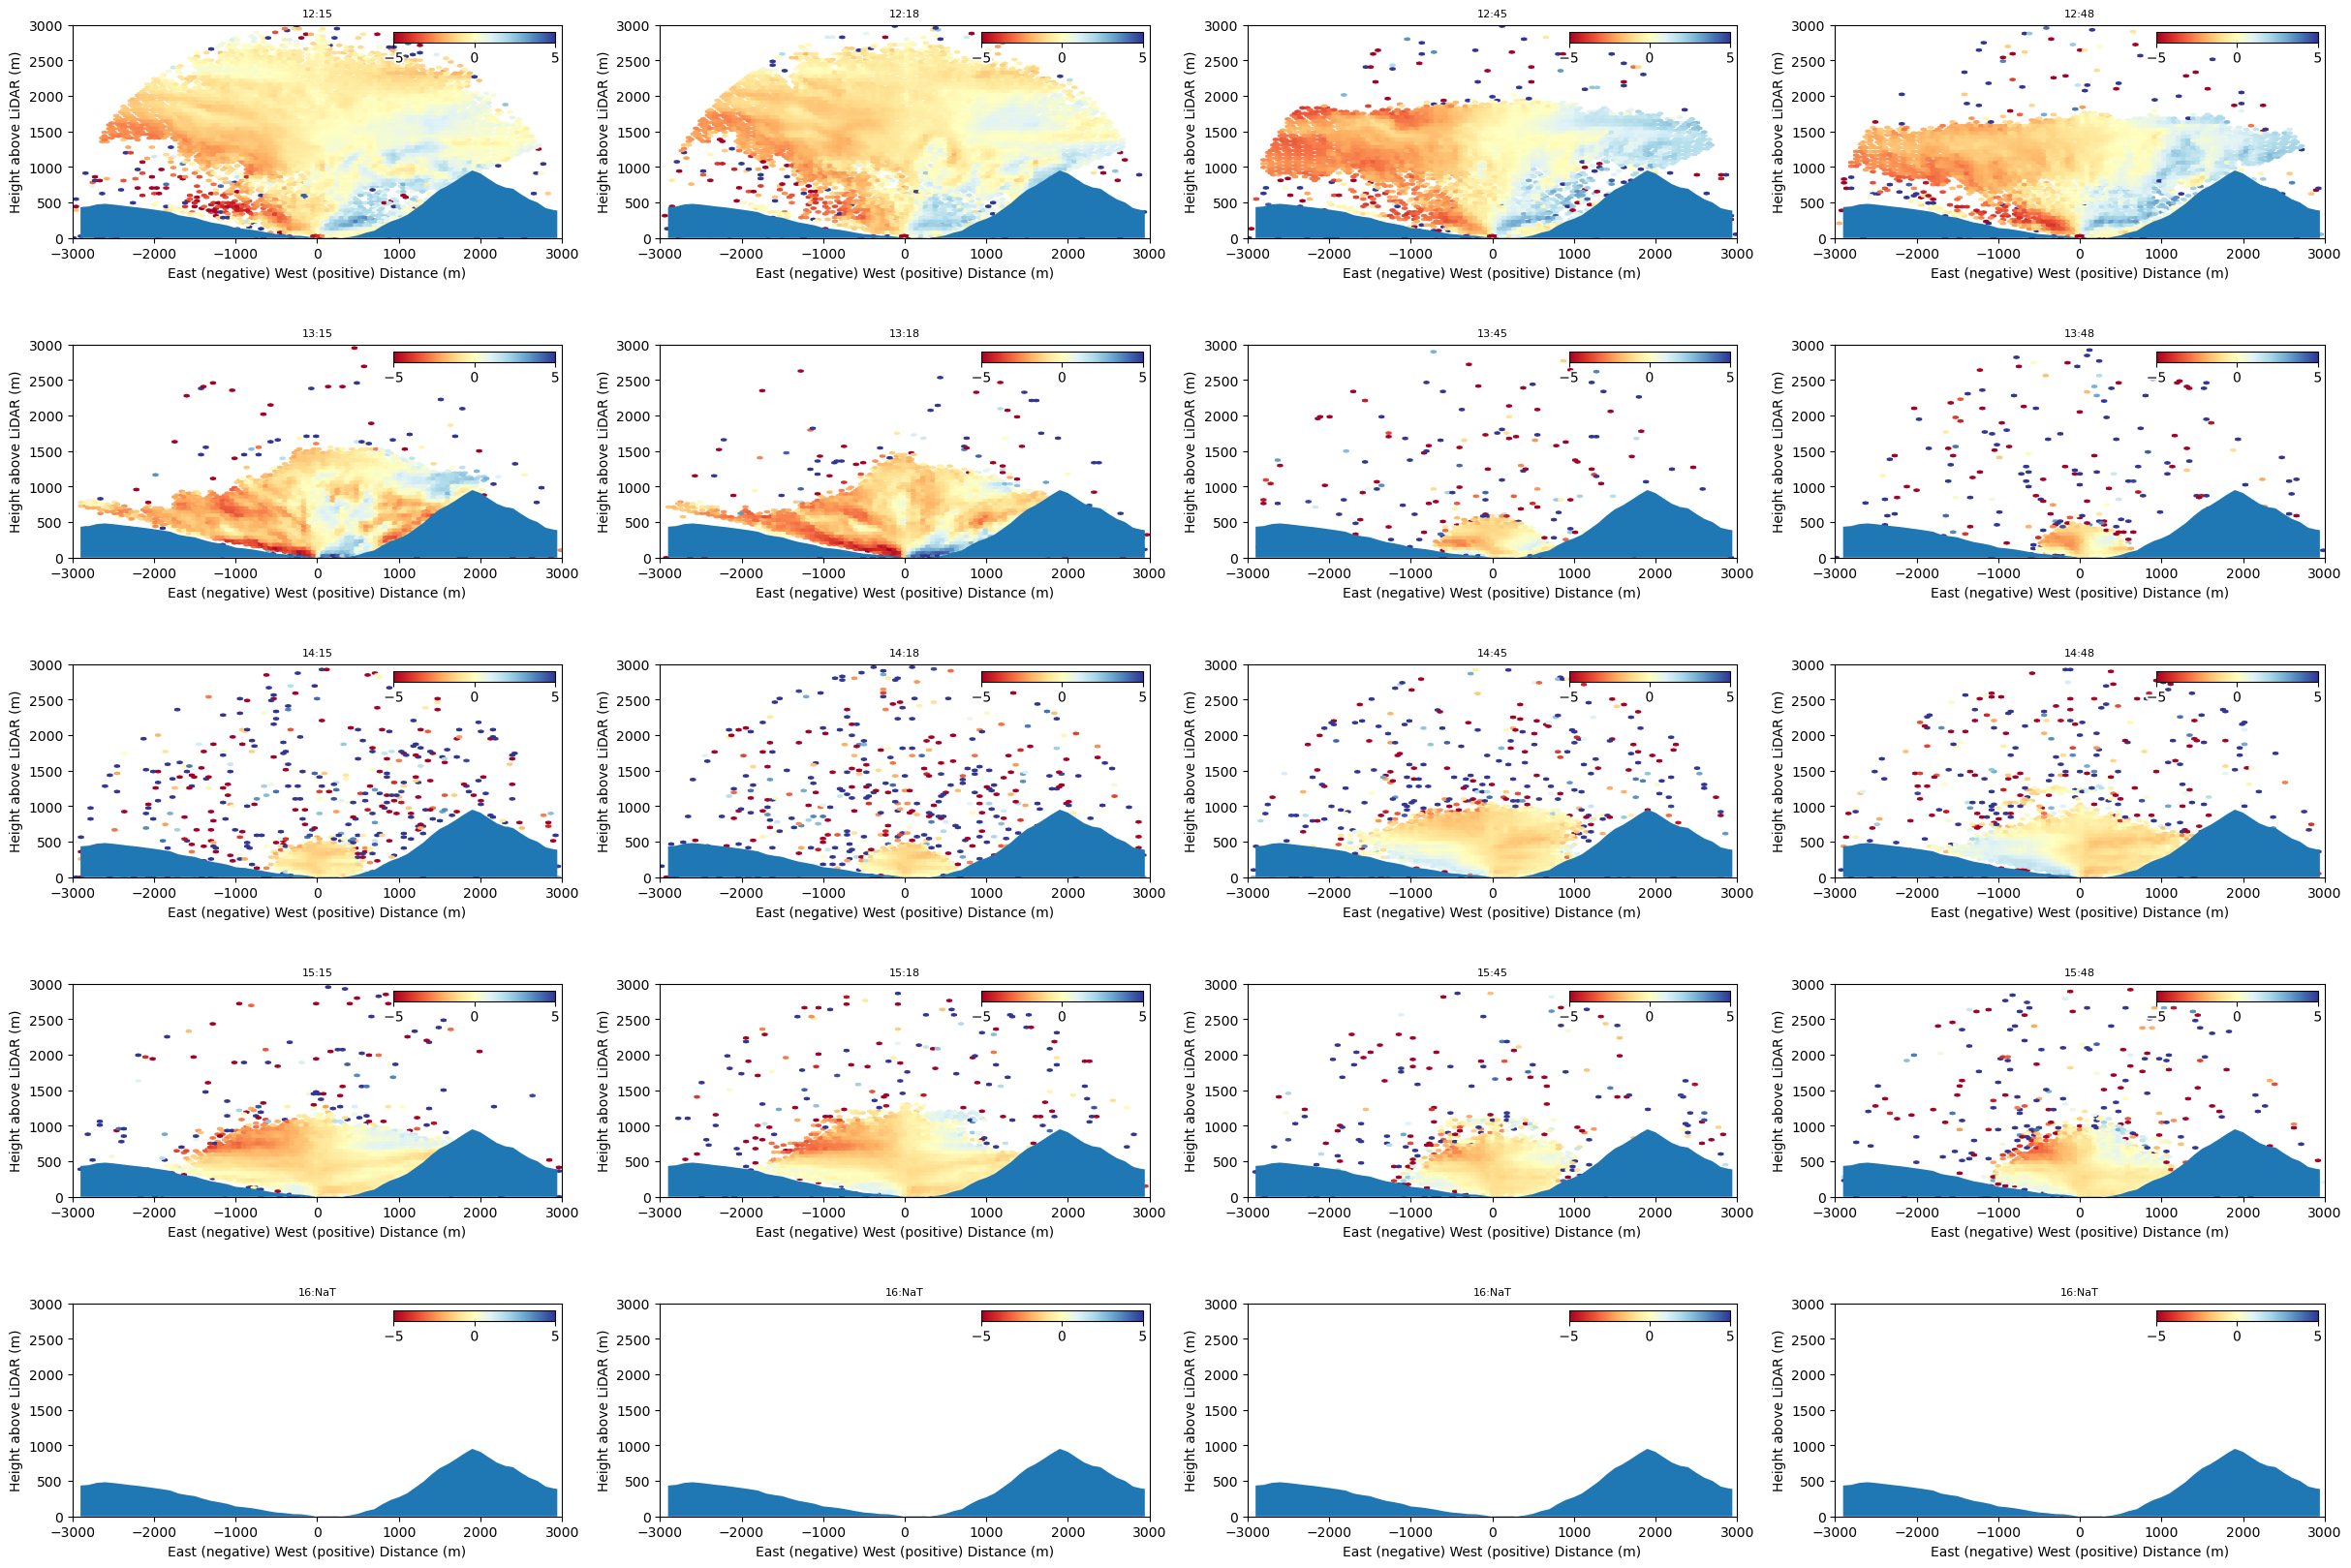

In [38]:
hours = np.linspace(12,16,5)
scan_n_options = ['15.00','18.00','45.00','48.00']
fig, axes = plt.subplots(
    len(hours),
    len(scan_n_options),
    figsize=(30,96),
)

for i_hour, hour in enumerate(hours):
    for i_scan_n, scan_n in enumerate(scan_n_options):
        ax = axes[i_hour][i_scan_n]
        src = xvalley_rhi_df.query(f"hour == {hour}")
        src = src[src['hourly_scan_n'] == scan_n]
        hexplot = ax.hexbin(
            src['x'], 
            src['z'], 
            C=src['radial_velocity'], 
            cmap='RdYlBu',
            vmin=-5,
            vmax=5
        )
        ax.set_xlabel("East (negative) West (positive) Distance (m)")
        ax.set_ylabel("Height above LiDAR (m)")
        hour_str = f"{int(hour):02d}" if not np.isnan(int(hour)) else "NaT"
        minute_str = f"{int(src['minute'].min()):02d}" if not np.isnan(src['minute'].min()) else "NaT"
        ax.title.set_text(f"{hour_str}:{minute_str}")
        ax.title.set_fontsize(8)
        ax.set_xlim(-3000, 3000)
        ax.set_ylim(0, 3000)
        axins = inset_axes(
            ax,
            width="33%",
            height="5%",
            loc="upper right",
            # bbox_to_anchor=(1.05, 0., 1, 1)
        )
        ax.fill_between(xvalley_ground_profile['distance'], 0, xvalley_ground_profile['elevation'])
        axins.xaxis.set_ticks_position("bottom")
        cbar = fig.colorbar(hexplot, cax=axins,  orientation="horizontal", ticks=[-5, 0, 5])
        [lab.set_fontweight(500) for lab in cbar.ax.get_xticklabels()]
        [lab.set_path_effects([pe.withStroke(linewidth=3, foreground="white")]) for lab in cbar.ax.get_xticklabels()]

plt.subplots_adjust(hspace=0.25)

# Label the 4 valley-wise scans that happen each hour

In [39]:
valley_rhi_df['hourly_seconds'] = valley_rhi_df.apply(lambda row: row['minute']*60 + row['second'], axis=1)
valley_rhi_df['hourly_scan_n'] = pd.cut(
    valley_rhi_df['hourly_seconds'],
    [22, 214, 1804, 2014, 3599],
    labels=['00.00','03.00','30.00','33.00']
)

/tmp/ipykernel_458277/4263518976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valley_rhi_df['hourly_seconds'] = valley_rhi_df.apply(lambda row: row['minute']*60 + row['second'], axis=1)
/tmp/ipykernel_458277/4263518976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valley_rhi_df['hourly_scan_n'] = pd.cut(


In [41]:
valley_ground_profile = sosutils.get_radar_scan_ground_profile(
    lon =     dl_rhi['lon'].values[0],
    lat =     dl_rhi['lat'].values[0],
    bearing =     valley_rhi_df.azimuth.unique()[0],
    radius =     3, #km
    spacing = 100 #meters
)

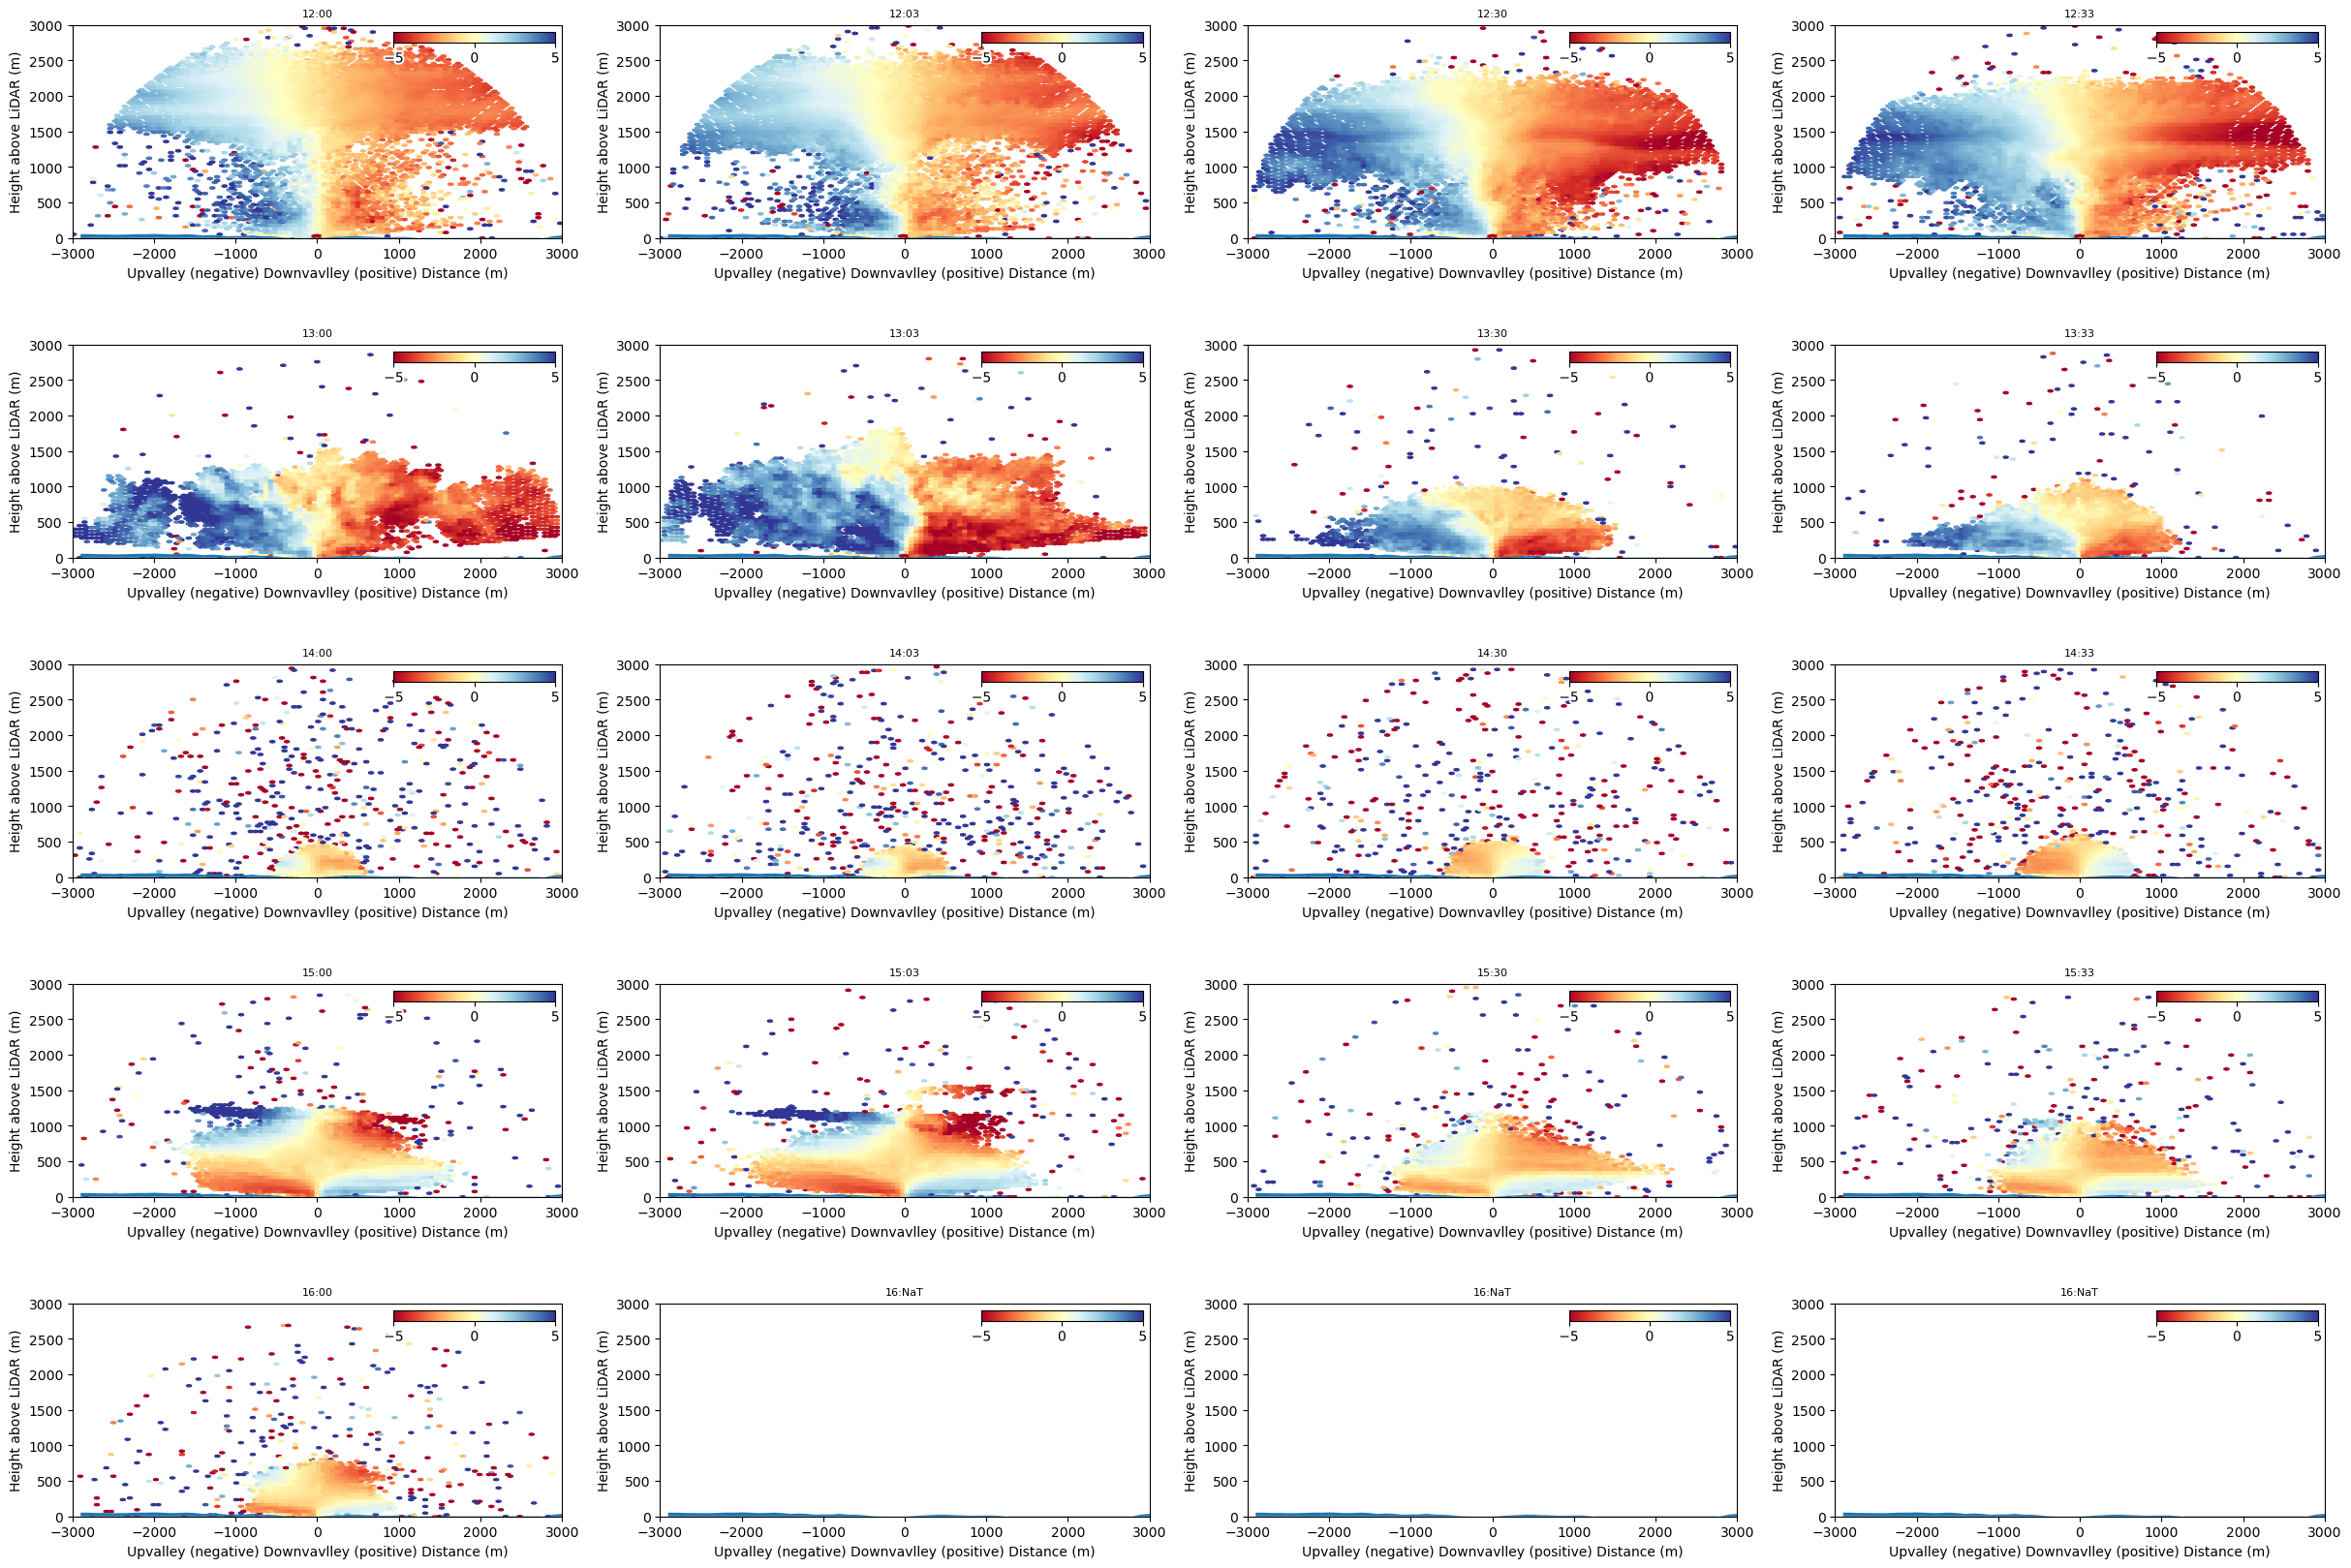

In [42]:
hours = np.linspace(12,16,5)
scan_n_options = ['00.00','03.00','30.00','33.00']
fig, axes = plt.subplots(
    len(hours),
    len(scan_n_options),
    figsize=(30,20), 
    # sharex=True, sharey=True
)

for i_hour, hour in enumerate(hours):
    for i_scan_n, scan_n in enumerate(scan_n_options):
        ax = axes[i_hour][i_scan_n]
        src = valley_rhi_df.query(f"hour == {hour}")
        src = src[src['hourly_scan_n'] == scan_n]
        hexplot = ax.hexbin(
            src['x'], 
            src['z'], 
            C=src['radial_velocity'], 
            cmap='RdYlBu',
            vmin=-5,
            vmax=5
        )
        ax.set_xlabel("Upvalley (negative) Downvavlley (positive) Distance (m)")
        ax.set_ylabel("Height above LiDAR (m)")
        hour_str = f"{int(hour):02d}" if not np.isnan(int(hour)) else "NaT"
        minute_str = f"{int(src['minute'].min()):02d}" if not np.isnan(src['minute'].min()) else "NaT"
        ax.title.set_text(f"{hour_str}:{minute_str}")
        ax.title.set_fontsize(8)
        ax.set_xlim(-3000, 3000)
        ax.set_ylim(0, 3000)
        axins = inset_axes(
            ax,
            width="33%",
            height="5%",
            loc="upper right",
            # bbox_to_anchor=(1.05, 0., 1, 1)
        )
        ax.fill_between(valley_ground_profile['distance'], 0, valley_ground_profile['elevation'])
        axins.xaxis.set_ticks_position("bottom")
        cbar = fig.colorbar(hexplot, cax=axins,  orientation="horizontal", ticks=[-5, 0, 5])
        [lab.set_fontweight(500) for lab in cbar.ax.get_xticklabels()]
        [lab.set_path_effects([pe.withStroke(linewidth=3, foreground="white")]) for lab in cbar.ax.get_xticklabels()]
plt.subplots_adjust(hspace=0.5)
